# Analysis of Real Data from the PDHD Detector

Once you're comfortable with the simplified MC data, the next step is to analyze real data collected by the ProtoDUNE Horizontal Drift (PDHD) detector. 
**This notebook focuses on the run 32974, TPC=2, event=32, collection plane.**

As a surface detector, PDHD is continuously bombarded by cosmic rays, resulting in multiple overlapping tracks within each recorded event. For these data dead channels (overactivity with no real physical signal) have already been masked.

In [113]:
import uproot #Uproot is a Python library that allows you to read, write, and manipulate ROOT files without requiring ROOT or C++.
import awkward as ak #this is for ragged data handling, which is common in particle physics data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
# %matplotlib widget 
warnings.filterwarnings('ignore') # Ignore warnings for cleaner output

filepath = "../data/pdhd_run032974_tps.root"    

with uproot.open(filepath) as file:
    tree = file["triggerana/tree"]  # Adjust the path if your tree is elsewhere
    print(tree.keys())  # This prints all branch names in the tree

['event', 'run', 'subrun', 'TP_channel', 'TP_startT', 'TP_peakT', 'TP_TOT', 'TP_SADC', 'TP_peakADC', 'TP_plane', 'TP_TPC']


In [114]:
#instead of using all the branches, we can specify which ones we want to read
def load_data(filepath, branch_names, max_events=3000):
    """Load data from a ROOT file into a pandas DataFrame."""
    try:
        with uproot.open(filepath) as file:
            tree = file["triggerana/tree"]
            arrays = tree.arrays(branch_names, library="ak", entry_stop=max_events)
            return ak.to_dataframe(arrays)
    except Exception as e:
        print(f"Error loading data from {filepath}: {e}")
        return None

# name of branches in the TTree to read into the pandas df
TP_BRANCHES_df = ['event', 'run', 'subrun', 'TP_channel', 'TP_startT', 'TP_peakT', 'TP_TOT', 'TP_SADC', 'TP_peakADC', 'TP_plane', 'TP_TPC'] #trigger primitives for real data

In [115]:
#Let's load the data from runs
df_32974= load_data(filepath, TP_BRANCHES_df, 10000)
df_32974.run_name = "Cosmic run 32974"

In [116]:
#Let's see what event IDs exist in the file
triggers = df_32974.event.unique()
print(f"Event {triggers}")

Event [  8  16  24  32  40  48  56  64  72  80  88  96 104 112 120 128 136 144
 152 160 168 176 184 192 200 208 216 224 232 240 248 256 264 272 280 288
 296 304 360 368]


In [117]:
# Global variable for APA ranges
apa_ranges = {
    "APA1": (0, 2560),
    "APA3": (2560, 5120),
    "APA2": (5120, 7680),
    "APA4": (7680, 10240),
}

In [185]:
event=56
plane=2
TPC=2

def make_title(run, event, TPC, plane, cuts="no cuts"):
    return f"Run {run} | Event {event} | TPC {TPC} | Plane {plane} | {cuts}"

### Characteristics of a single run, single event, collection plane hits of a single TPC. 

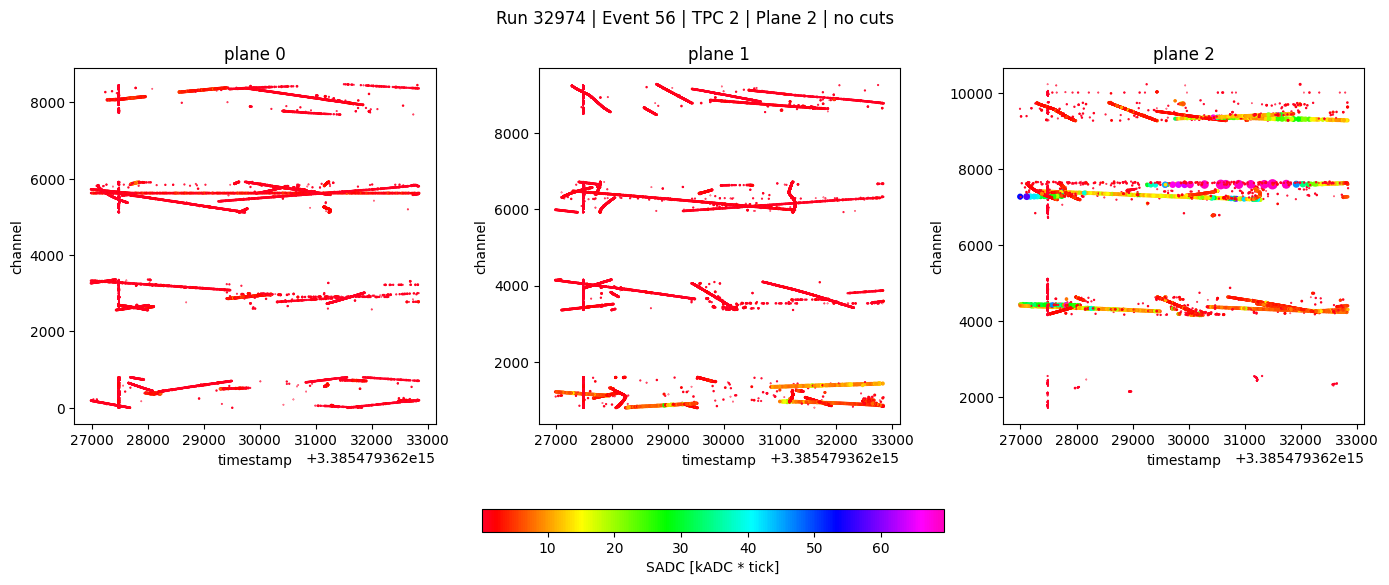

In [ ]:
#timestamps correspond to microseconds, the big number is the first detection hit in timestamp
# Note: APA1 collection plane is broken so we will not use it in this analysis.

tps_32974 = df_32974[(df_32974.event == event)]
tps_32974.run_name = "Cosmic run 32974"
vmin, vmax = tps_32974["TP_SADC"].min()/1e3, (tps_32974["TP_SADC"].max()/1e3)/2
fig, ax = plt.subplots(1, 3, figsize=(14, 6))

for plane in range(3):
    tps = tps_32974[tps_32974.TP_plane == plane]
    sc = ax[plane].scatter(tps.TP_peakT, tps.TP_channel, s=tps.TP_TOT / 10, c=tps.TP_SADC/1e3, cmap='gist_rainbow', vmin=vmin, vmax=vmax)
    ax[plane].set_xlabel("timestamp")
    ax[plane].set_ylabel("channel")
    ax[plane].set_title(f"plane {plane}")   
    
plt.suptitle(make_title(tps['run'].unique()[0], event, TPC, plane))
fig.colorbar(sc, ax=ax, orientation='horizontal', fraction=0.05, pad=-0.3).set_label("SADC [kADC * tick]")
plt.tight_layout()
plt.show()

- Induction planes appear to be noisier and have less SADC variations.
- Increased noise due to pile-up of simultaneous activity.
- More variable noise levels compared to MC simulations, and noisy/dead channels (which can change across multiple trigger records, as the data taking conditions are never exactly the same!)

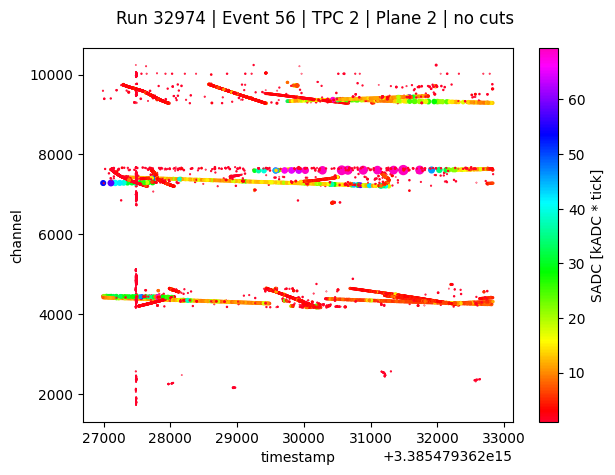

In [218]:
vmin, vmax = 1, (tps_32974["TP_SADC"].max()/1e3)/2
plt.figure()

tps = tps_32974[tps_32974.TP_plane == plane]
tps.run_name = "Cosmic run 32974"
sc = plt.scatter(tps.TP_peakT, tps.TP_channel, s=tps.TP_TOT / 10, c=tps.TP_SADC/1e3, cmap='gist_rainbow', vmin=vmin, vmax=vmax)
plt.xlabel("timestamp")
plt.ylabel("channel")

plt.suptitle(make_title(tps['run'].unique()[0], event, TPC, plane))
cbar = plt.colorbar(sc)
cbar.set_label("SADC [kADC * tick]")
plt.tight_layout()
plt.show()

In [175]:
print(f"TP_SADC: Minimum value {tps['TP_SADC'].min()/1e3}, maximum {(tps['TP_SADC'].max()/1e3)}, mean {tps['TP_SADC'].mean()/1e3}, std deviation {tps['TP_SADC'].std()/1e3}")
print(f"TP_PeakADC: Minimum value {tps['TP_peakADC'].min()}, maximum {(tps['TP_peakADC'].max())}, mean {tps['TP_peakADC'].mean()}, std deviation {tps['TP_peakADC'].std()}")
print(f"TP_TOT: Minimum value {tps['TP_TOT'].min()}, maximum {(tps['TP_TOT'].max())}, mean {tps['TP_TOT'].mean()}, std deviation {tps['TP_TOT'].std()}")


TP_SADC: Minimum value 0.061, maximum 138.8, mean 4.02704966425947, std deviation 6.5962281779196665
TP_PeakADC: Minimum value 61, maximum 3875, mean 372.8781198530343, std deviation 281.2000937872943
TP_TOT: Minimum value 1, maximum 414, mean 13.710756366400608, std deviation 15.949913116750578


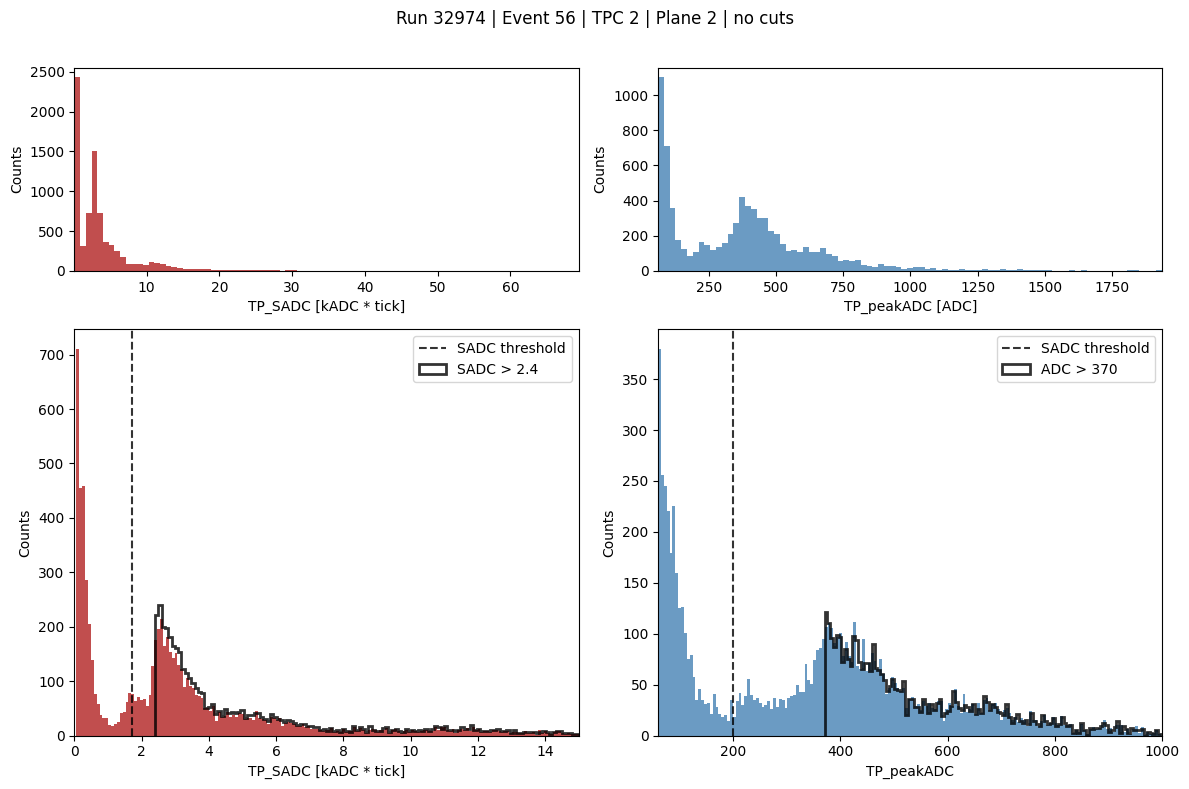

In [238]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw={'height_ratios': [1, 2]})

plt.suptitle(make_title(tps['run'].unique()[0], event, TPC, plane))

# LEFT: TP_SADC
axs[0, 0].hist(tps['TP_SADC']/1e3, bins=int(2*np.sqrt(len(tps))), alpha=0.8, color='firebrick')
axs[0, 0].set_xlabel('TP_SADC [kADC * tick]')
axs[0, 0].set_ylabel('Counts')
axs[0, 0].set_xlim(tps['TP_SADC'].min()/1e3, tps['TP_SADC'].max()/2e3)

mask_sadc = (tps['TP_SADC']/1e3 >= 0) & (tps['TP_SADC']/1e3 <= 15)
tps_zoom_sadc = tps[mask_sadc]
axs[1, 0].hist(tps_zoom_sadc['TP_SADC']/1e3, bins=int(2*np.sqrt(len(tps_zoom_sadc))),alpha=0.8, color='firebrick')
axs[1, 0].set_xlabel('TP_SADC [kADC * tick]')
axs[1, 0].set_ylabel('Counts')
axs[1, 0].set_xlim(0, 15)

axs[1, 0].axvline(1.7, color='black', linestyle='--', alpha=0.8, label='SADC threshold')
threshold_sadc = 2.4
sadc_cut = tps_zoom_sadc[tps_zoom_sadc['TP_SADC']/1e3 > threshold_sadc]
axs[1, 0].hist(sadc_cut['TP_SADC']/1e3, bins=int(2*np.sqrt(len(sadc_cut))),
               histtype='step', color='black', linewidth=2, alpha=0.8, label='SADC > 2.4')
axs[1, 0].legend()

# CENTRAL: TP_peakADC
axs[0, 1].hist(tps['TP_peakADC'], bins=int(2*np.sqrt(len(tps))), alpha=0.8, color='steelblue')
axs[0, 1].set_xlabel('TP_peakADC [ADC]')
axs[0, 1].set_ylabel('Counts')
axs[0, 1].set_xlim(tps['TP_peakADC'].min(), tps['TP_peakADC'].max()/2)

mask_adc = (tps['TP_peakADC'] >= 61) & (tps['TP_peakADC'] <= 1000)
tps_zoom_adc = tps[mask_adc]
axs[1, 1].hist(tps_zoom_adc['TP_peakADC'], bins=int(2*np.sqrt(len(tps_zoom_adc))), alpha=0.8, color='steelblue')
axs[1, 1].set_xlabel('TP_peakADC')
axs[1, 1].set_ylabel('Counts')
axs[1, 1].set_xlim(61, 1000 )

axs[1, 1].axvline(200, color='black', linestyle='--', alpha=0.8, label='SADC threshold')
threshold_adc = 370
adc_cut = tps_zoom_adc[tps_zoom_adc['TP_peakADC'] > threshold_adc]
axs[1, 1].hist(adc_cut['TP_peakADC'], bins=int(2*np.sqrt(len(adc_cut))),
               histtype='step', color='black', linewidth=2, alpha=0.8,label='ADC > 370')
axs[1, 1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

- Clearly a presence of peak at lower energy and lower thresholds (noisier data)

    The small bump is connected to the actual presence of MIP

- The noise we are seeing i the small contribution of natural radioactivity of Liquid Argon 39

Total time for event: 5847 ticks, 2.9235 s
Number of unique timestamps: 3611  of duration 500 ns
Mean duration between timestamps: 1.6196675900277009
Std deviation of durations: 1.3421365941758865
Min duration: 1
Max duration: 19


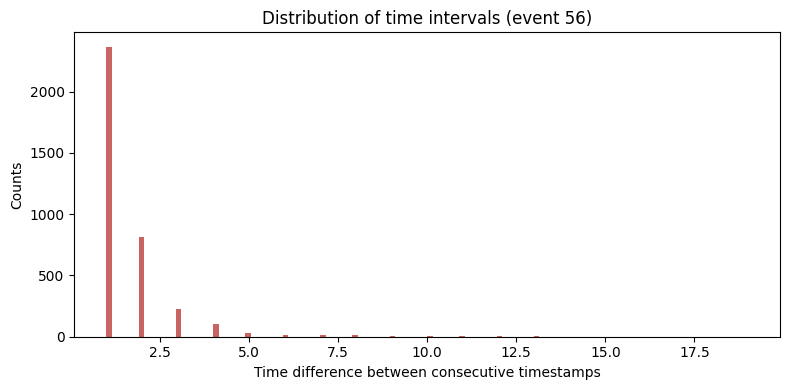

In [213]:
total_time = tps["TP_peakT"].max() - tps["TP_peakT"].min()
print(f"Total time for event: {total_time} ticks, {total_time*500/1e6} s") #ticks occur every 500 ns
num_timestamps = tps["TP_peakT"].nunique()
print("Number of unique timestamps:", num_timestamps, " of duration 500 ns")  #During event reconstruction and data storage, the same timestamp (tick value) is assigned to all channels/wires for that sampling instant.

# Time differences between consecutive timestamps
sorted_timestamps = np.sort(tps["TP_peakT"].unique())
time_diffs = np.diff(sorted_timestamps)
print("Mean duration between timestamps:", np.mean(time_diffs))
print("Std deviation of durations:", np.std(time_diffs))
print("Min duration:", np.min(time_diffs))
print("Max duration:", np.max(time_diffs))

#Sparse and Irregular Hit Times:
#   You have many ticks where no new hit occurs (no threshold crossing, no pulse peak is found on any channel at that tick).
#   As a result, the time stamps for hits are separated by multiple ticks, depending on where and when a pulse maximum is detecte

plt.figure(figsize=(8,4))
plt.hist(time_diffs, bins=int(2*np.sqrt(len(time_diffs))), color='firebrick', alpha=0.7)
plt.xlabel("Time difference between consecutive timestamps")
plt.ylabel("Counts")
plt.title("Distribution of time intervals (event {})".format(event))
plt.tight_layout()
plt.show()



- The readout is the ADC counts as a function of ticks, 500 ns on each channel. Each event spans 3s circa.  

### Looking into thresholds and noise removal

In [ ]:
def plot_TPC_activity(tp_df, thresh, vmin=None, vmax=None, show_counts=True):
    global apa_ranges 
    title_prefix="TP Activity per APA"
    filtered = tp_df[tp_df.TP_peakADC > thresh]
    make_title(tps['run'].unique()[0], event, TPC, plane, "threshold: ")
    
    print(f"Threshold: {thresh} (TPs: {len(filtered)}, Retaining {len(filtered)/len(tp_df)*100:.2f}% of raw TP)")
    run_type = tp_df.run_name
    plot_title = f"{title_prefix} ({run_type}, threshold: {thresh:.0f} ADC)"

    # --- Scatter plots ---
    fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True)
    for i, (apa, (start, stop)) in enumerate(apa_ranges.items()):
        ax = axs[i//2][i%2]
        df_apa = filtered[(filtered.TP_channel >= start) & (filtered.TP_channel < stop)]
        sc = ax.scatter(
            df_apa.TP_peakT, df_apa.TP_channel,
            s=df_apa.TP_TOT / 10,
            c=df_apa.TP_SADC if thresh is not None else df_apa.TP_SADC / 1e3,
            cmap="gist_rainbow",
            alpha=0.7,
            edgecolor="none",
            vmin=vmin, vmax=vmax
        )
        ax.set_title(f"{apa} (channels {start}-{stop-1})")
        ax.set_xlabel("timestamp")
        ax.set_ylabel("TP_channel")
        ax.grid(True, linestyle="dotted", alpha=0.5)

    plt.suptitle(f"{plot_title}", fontsize=18)
    if thresh is not None:
        fig.colorbar(sc, ax=axs, orientation="vertical", shrink=0.8, label="TP SADC")
    plt.show()

    # --- Bar plot: TP count per APA ---
    if show_counts:
        apa_counts = [
            len(filtered[(filtered.TP_channel >= start) & (filtered.TP_channel < stop)])
            for (start, stop) in apa_ranges.values()
        ]s
        plt.figure(figsize=(8, 5))
        plt.bar(apa_ranges.keys(), apa_counts, color='steelblue')
        plt.ylabel("Number of TPs")
        plt.title(f"Total TP Count per APA ({'threshold: ' + str(thresh) if thresh is not None else 'no cut'})")
        plt.show()

Threshold: 370 (TPs: 3889, Retaining 49.27% of raw TP)


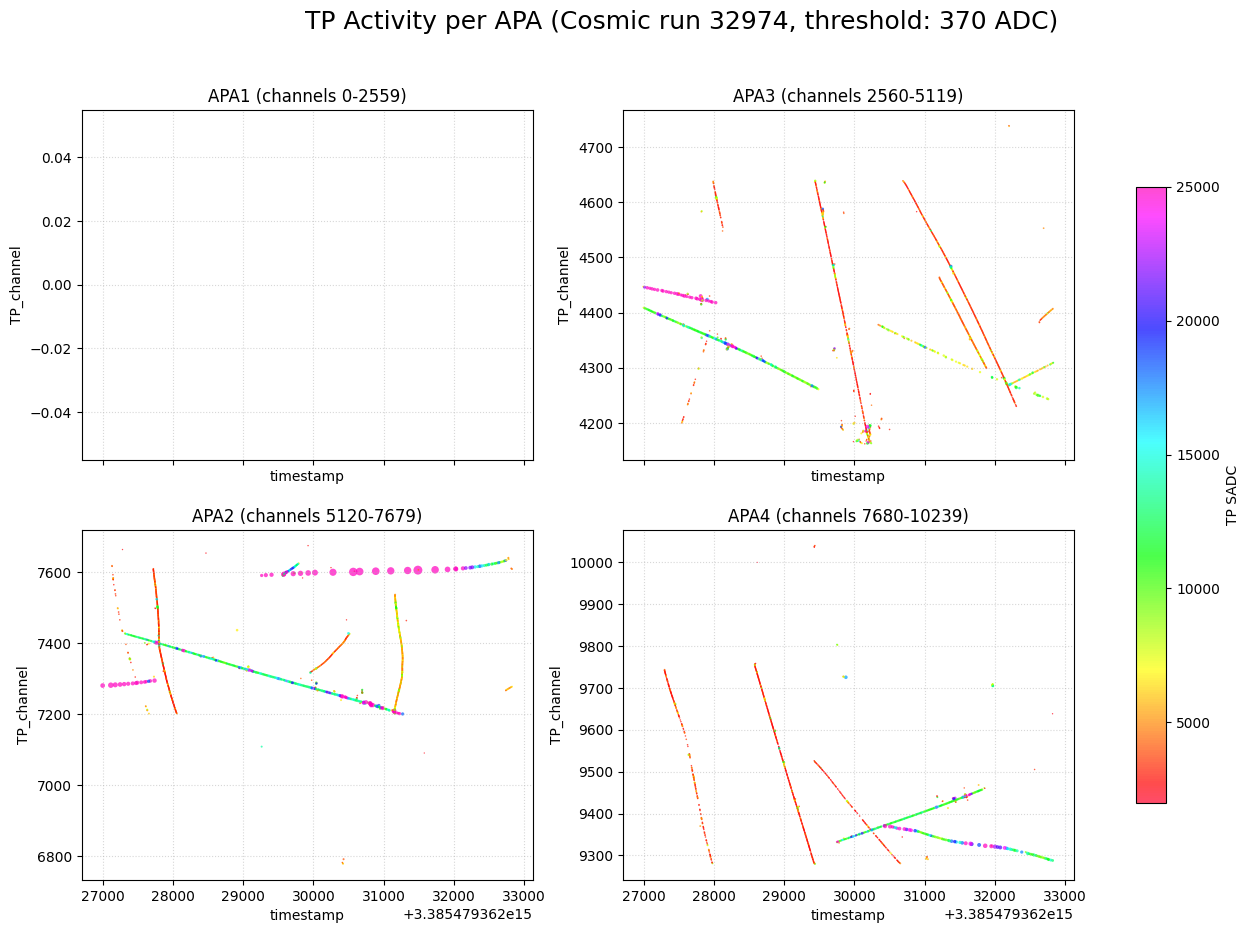

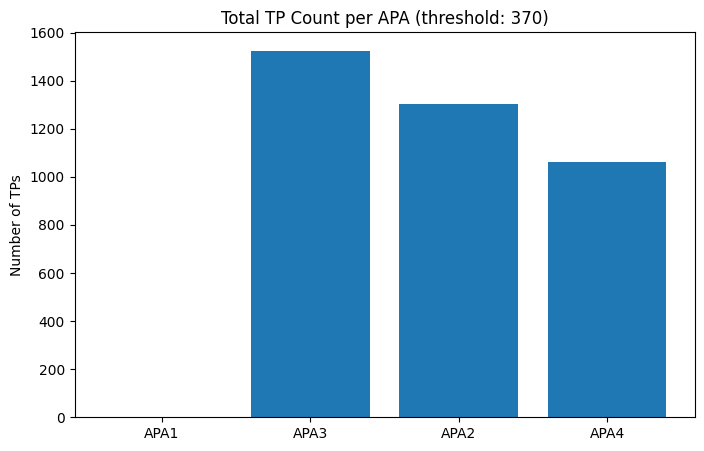

In [240]:
plot_TPC_activity(tps, thresh=370, vmin=2000, vmax= 25000)

### Quantify visible energy x activity per APA

In [ ]:
def quantify_visible_energy_APA(tps, time_window_us=10000, adc_tick_to_mev=0.039):
    """
    Computes the visible energy (sum of TP_SADC × conversion) per time window for each APA.
    Returns a dict {APA_name: (energy_per_window, energy_stats)}
    """
    global apa_ranges

    apa_energy = {}
    for apa, (start, stop) in apa_ranges.items():
        df_apa = tps[(tps.TP_channel >= start) & (tps.TP_channel < stop)]
        if df_apa.empty:
            apa_energy[apa] = (np.array([]), {'mean_E_per_window_MeV': 0, 'max_E_per_window_MeV': 0})
            continue
        tmin, tmax = df_apa.TP_peakT.min(), df_apa.TP_peakT.max()
        bins = np.arange(tmin, tmax + time_window_us, time_window_us)
        df_apa = df_apa.copy()
        df_apa["time_bin"] = np.digitize(df_apa.TP_peakT, bins) - 1
        energy_per_bin = df_apa.groupby('time_bin')['TP_SADC'].sum().reindex(range(len(bins)-1), fill_value=0)
        energy_per_bin_MeV = energy_per_bin.values * adc_tick_to_mev
        energy_stats = {
            'mean_E_per_window_MeV': np.mean(energy_per_bin_MeV),
            'max_E_per_window_MeV': np.max(energy_per_bin_MeV)
        }
        apa_energy[apa] = (energy_per_bin_MeV, energy_stats)
    return apa_energy


def plot_visible_energy_per_APA(apa_energy, bins=80, title_suffix=""):
    for apa, (energy_per_window, _) in apa_energy.items():
        if len(energy_per_window) == 0:
            continue
        # Rimuove outlier estremi per la visualizzazione
        max_plot_energy = np.quantile(energy_per_window, 0.999)
        plot_energies = energy_per_window[energy_per_window <= max_plot_energy]

        plt.figure(figsize=(10, 6))
        plt.hist(plot_energies, bins=bins, color='gray', alpha=0.7, edgecolor='black', label="Vis. energy per window")
        # Evidenzia le zone
        plt.axvspan(0, 5, color='blue', alpha=0.12, label='Below 5 MeV')
        plt.axvspan(5, 20, color='orange', alpha=0.15, label='5-20 MeV')
        plt.axvspan(20, plot_energies.max()+1, color='red', alpha=0.10, label='Above 20 MeV')
        plt.xlabel("Visible energy per window [MeV]", fontsize=14)
        plt.ylabel("Number of windows", fontsize=14)
        plt.title(f"{apa} - Visible energy per window {title_suffix}", fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()